In [1]:
%load_ext autoreload

In [3]:
%autoreload
import torch
import torch.nn as nn
import torchvision
import numpy as np
from gpt.model import ViT, Lambda
from gpt.data import MNISTDataModule
from tqdm.auto import tqdm
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms.functional as TF

In [4]:
mnist = MNISTDataModule()
mnist.setup()

In [5]:
tl = mnist.test_dataloader()

In [6]:
x, y = next(iter(tl))

In [38]:
# model = ViT(image_channels=1, image_size=(28, 28), patch_size=(2, 2)).cuda()
model = ViT.load_from_checkpoint('../train/lightning_logs/version_1009311/checkpoints/epoch=29-step=3540.ckpt')

In [15]:
def show(imgs, **kwargs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = TF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img), **kwargs)
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

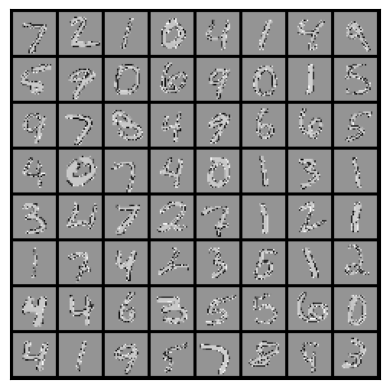

In [16]:
show(torchvision.utils.make_grid(x))

In [39]:
with torch.no_grad():
    out = model(x.cuda()).detach().cpu()

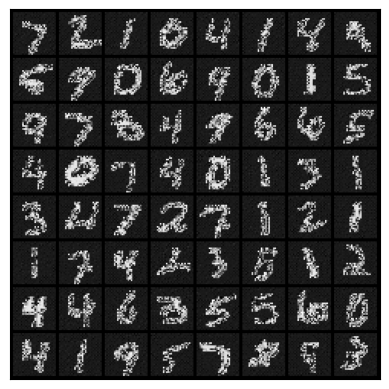

In [41]:
show(torchvision.utils.make_grid(out - x))